In [1]:
# --importing necessary libraries
import warnings
warnings.filterwarnings('ignore')

import yfinance as yfin
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose,STL

**Data Collection**

In [2]:
# this company list consists of the names of the companies that we tend to analyze
company_list = ['GOOGL','AMZN','MSFT']

# range of start_date to end_date for which data to be extracted
start_date = '2022-01-01'
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
# formatting the 'datetime' object into a string using 'strftime'

In [3]:
# creation of empty list to store individual dataframes downloaded
df_renew = []

#Iterating through each company in company_list
for firms in company_list:
    
    #downloading historical stock price data for a current company with the above mentioned date range
    data = yfin.download(firms, start_date, end_date, interval = '1d') # interval of 1-day
    
    # addition of a new column at the end of a dataframe, that consists only name of the current company
    data['Company'] = firms
    
    # appending the extracted data to the empty list created above
    df_renew.append(data)


# Stacking the obtained individual dataframe vertically
master_df = pd.concat(df_renew) # by default concatenation in pandas is done the axis 0, vertical

# reseting index such that the index after concatenation doesn't break in the middle as we concatenated
master_df.reset_index (inplace=True)

# sorting the dataframe using 'Data' and 'Company' column such that for each date, the data is obtained sequentially
sorted_df = master_df.sort_values(by=['Date','Company'], ascending=True)
sorted_df.head(3)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Company
592,2022-01-03,167.550003,170.703506,166.160507,170.404495,170.404495,63520000,AMZN
0,2022-01-03,145.054993,145.850998,143.712997,144.991501,144.991501,28646000,GOOGL
1184,2022-01-03,335.350006,338.000000,329.779999,334.750000,328.120911,28865100,MSFT


In [4]:
# as we resetted index on the master dataframe, after sorting the index again gets collapsed, so again an indexing is made freshly
sorted_df.reset_index(drop=True, inplace=True)

# inserting the 'Company' column in the first index, such that understanding the dataframe made ease.
sorted_df.insert(1,'Company',sorted_df.pop('Company'))
sorted_df.head(3)

,Date,Company,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,AMZN,167.550003,170.703506,166.160507,170.404495,170.404495,63520000
1,2022-01-03,GOOGL,145.054993,145.850998,143.712997,144.991501,144.991501,28646000
2,2022-01-03,MSFT,335.350006,338.000000,329.779999,334.750000,328.120911,28865100


**Data Understanding**

In [5]:
# copying the dataframe for futhur analysis, such that the original sorted dataframe is not distrubed for later use.
stock_df = sorted_df.copy()

# printing the shape of the stock dataframe
print(f"Stock Dataframe consists of {stock_df.shape[0]} records and {stock_df.shape[1]} columns")

print()

#printing the names of the columns in the dataframe
print(f"Column Names :{list(stock_df.columns)}")

Stock Dataframe consists of 1776 records and 8 columns

Column Names :['Date', 'Company', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [6]:
# retrieving the information of the dataframe
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1776 non-null   datetime64[ns]
 1   Company    1776 non-null   object        
 2   Open       1776 non-null   float64       
 3   High       1776 non-null   float64       
 4   Low        1776 non-null   float64       
 5   Close      1776 non-null   float64       
 6   Adj Close  1776 non-null   float64       
 7   Volume     1776 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 111.1+ KB


In [7]:
#checking for missing values

# counting the missing values and summing
missing_count = stock_df.isna().sum()

#calculating the percentage of missing values in stockdf
missing_percent = missing_count // len(stock_df)

#creating a dataframe, for ease understanding
missing_df = pd.concat([missing_count,missing_percent],axis=1,keys=['count','percent'])
missing_df

,count,percent
Date,0,0
Company,0,0
Open,0,0
High,0,0
Low,0,0
Close,0,0
Adj Close,0,0
Volume,0,0


In [8]:
#five point summary of a stock_df includes mean,median,percentiles for understanding distribution of values on each numerical columns

stock_df.describe(include=np.number)

,Open,High,Low,Close,Adj Close,Volume
count,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1.776000e+03
mean,187.316052,189.500693,185.091221,187.342020,186.481227,4.177277e+07
std,94.207142,94.828253,93.426515,94.169852,93.284234,2.505084e+07
min,82.800003,83.480003,81.430000,81.820000,81.820000,9.200800e+06
25%,116.426622,118.317499,114.971626,116.618248,116.618248,2.521430e+07
50%,141.104996,142.995247,139.510002,141.034996,141.034996,3.418670e+07
75%,259.914993,264.117500,255.984997,260.437492,256.365051,5.104815e+07
max,429.829987,430.820007,427.160004,429.369995,429.369995,2.726620e+08


**Visualization**

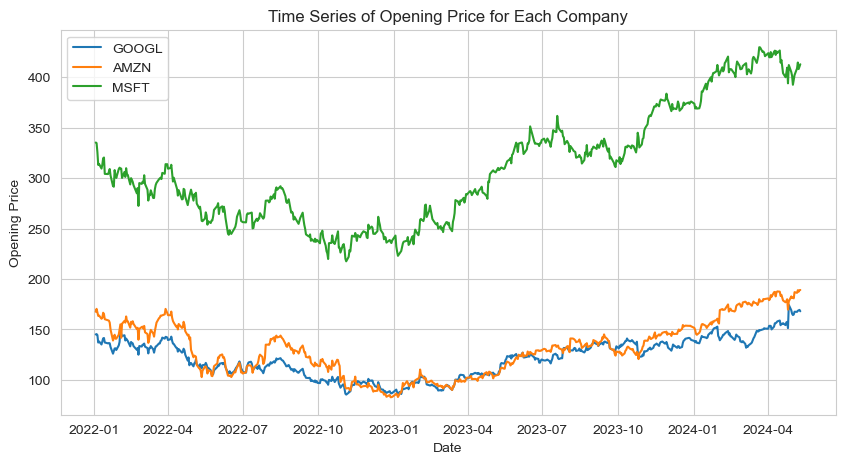

In [9]:
 # setting the white gird style background 
sns.set_style("whitegrid")

# setting the size of the chart
plt.figure(figsize=(10, 5))

# iterating through each company in company list
for company in company_list:
    # filtering out datas for the current company
    company_data = stock_df[stock_df['Company'] == company]
    # ploting the time series for opening price as Data in x-axis and 'Open' in y-axis
    plt.plot(company_data['Date'], company_data['Open'], label=company)

# naming the title for the chart
plt.title('Time Series of Opening Price for Each Company')

# labeling the x-axis as date
plt.xlabel('Date')

#labeling the y-axis as 'Opening Price'
plt.ylabel('Opening Price')

# displaying company names in company list as legend for the chart 
plt.legend()

#showing the plot
plt.show()

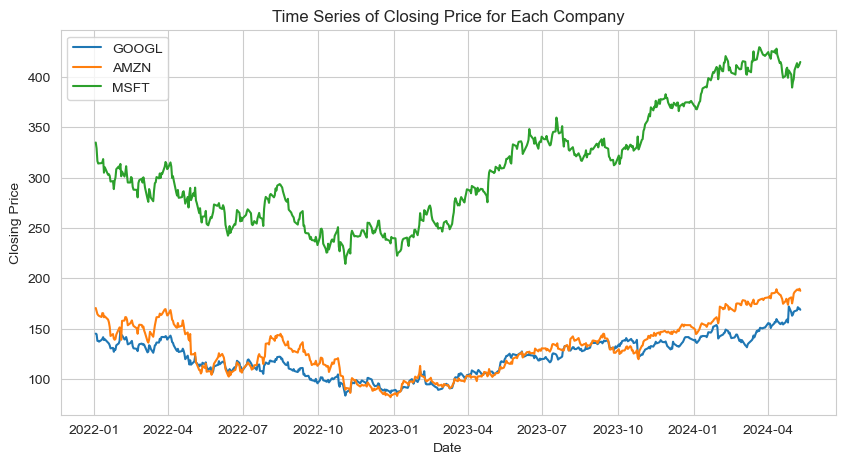

In [10]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 5))
for company in company_list:
    company_data = stock_df[stock_df['Company'] == company]
    # ploting time series chart for 'Closing Price' 
    plt.plot(company_data['Date'], company_data['Close'], label=company)

plt.title('Time Series of Closing Price for Each Company')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

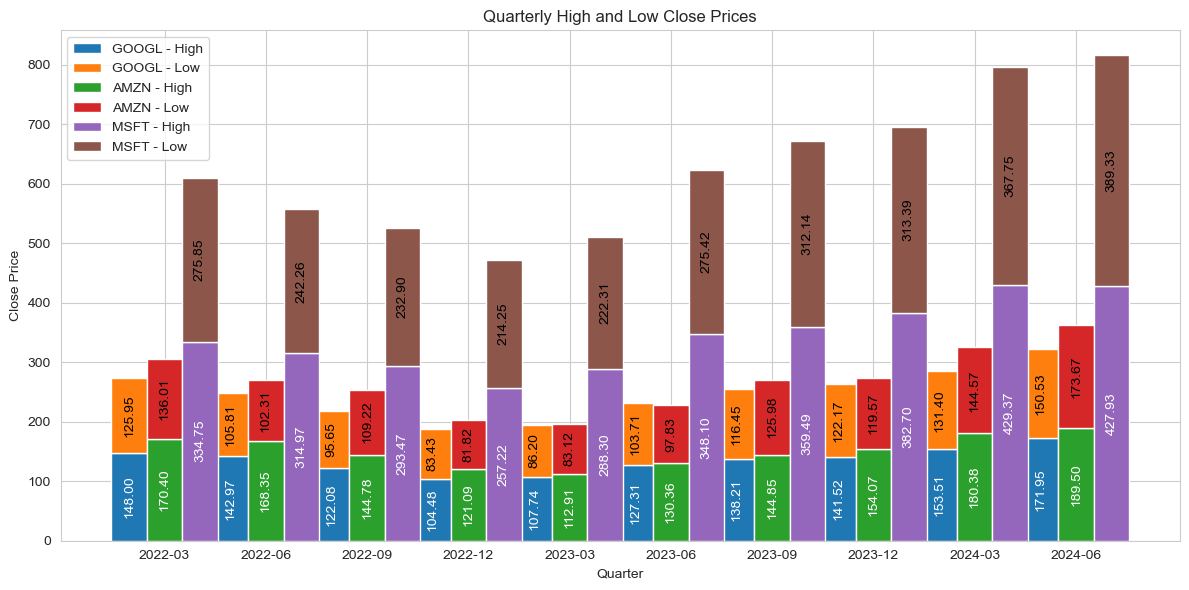

In [11]:
# grouping the stock dataset by qarterly format and calculating the maximum and minimum close price for each company
quarterly_data = stock_df.groupby([pd.Grouper(key='Date', freq='Q'), 'Company']).agg({'Close': ['max', 'min']}).reset_index()


plt.figure(figsize=(12, 6))
for i, company in enumerate(company_list):
    #filtering the quarterly data for the current company
    company_data = quarterly_data[quarterly_data['Company'] == company]
    #generating x-axis ticks for each quarter
    quarters = np.arange(len(company_data))
    #setting the width for each bar
    bar_width = 0.35 
    
    #plotting high prices
    plt.bar(quarters + i * bar_width, company_data[('Close', 'max')], bar_width, label=f'{company} - High')
    
    #plotting low prices, stacked on top of high prices
    plt.bar(quarters + i * bar_width, company_data[('Close', 'min')], bar_width, label=f'{company} - Low', bottom=company_data[('Close', 'max')])

    # annotating high price and low prices inside the bars and tilting the values inside the bar vertically
    for quarter, high, low in zip(quarters, company_data[('Close', 'max')], company_data[('Close', 'min')]):
        plt.text(quarter + i * bar_width, high / 2, f'{high:.2f}', ha='center', va='center', color='white', rotation=90)
        plt.text(quarter + i * bar_width, high + low / 2, f'{low:.2f}', ha='center', va='center', color='black', rotation=90)

plt.title('Quarterly High and Low Close Prices')
plt.xlabel('Quarter')
plt.ylabel('Close Price')
plt.xticks(quarters + bar_width * (len(company_list) - 1) / 2, quarterly_data['Date'].dt.strftime('%Y-%m').unique())  # Set x-axis ticks to quarters
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

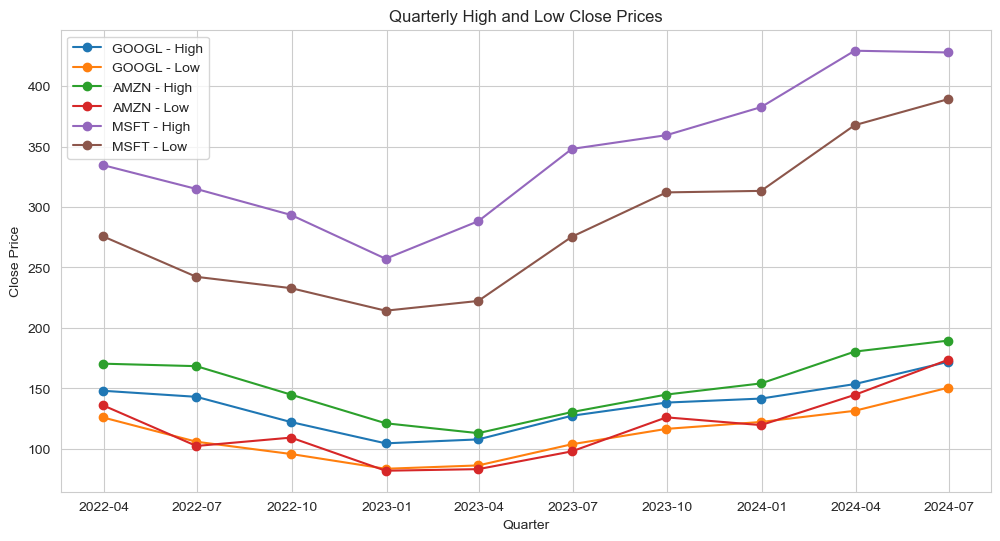

In [12]:
plt.figure(figsize=(12, 6))
for company in company_list:
    company_data = quarterly_data[quarterly_data['Company'] == company]
    #plotting the quarterly high prices with 'o' markers
    plt.plot(company_data['Date'], company_data[('Close', 'max')], label=f'{company} - High', marker='o')
    #plotting the quarterly low prices with 'o' markers
    plt.plot(company_data['Date'], company_data[('Close', 'min')], label=f'{company} - Low', marker='o')

plt.title('Quarterly High and Low Close Prices')
plt.xlabel('Quarter')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

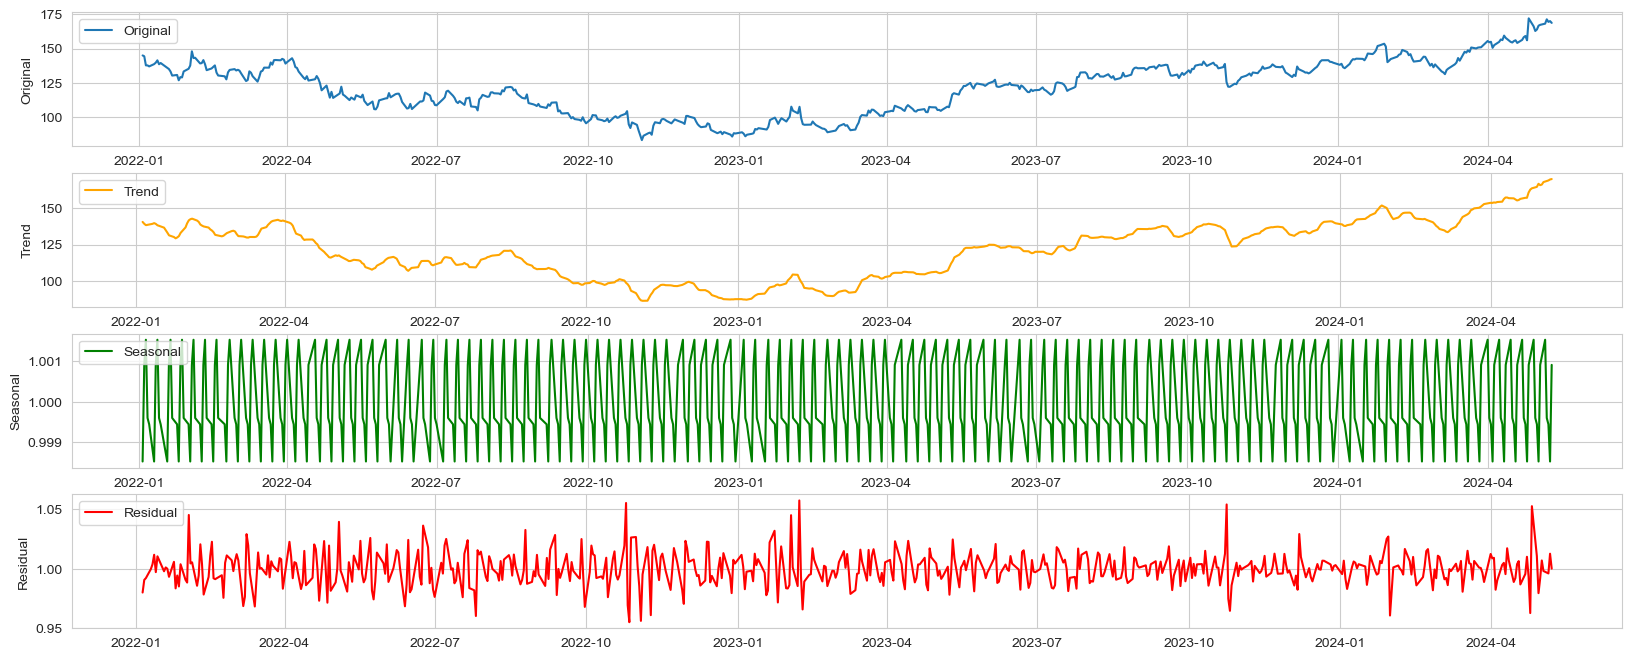

In [13]:
# filtering the dataset that consists of only 'GOOGL' data
google_data = stock_df[stock_df['Company']=='GOOGL']

# creating a new dataframe to convert date as index
google_df = pd.DataFrame(index = google_data['Date'])

#adding a column 'Close' that consists of closing price values of google data
google_df['Close'] = google_data['Close'].values

#performing a seasonal decomposition on the 'Close' price using multiplicative model
google_decompose = seasonal_decompose(google_df['Close'], model='multiplicative', period=5)

# summing trend, seasonal and residual components 
res = google_decompose.trend + google_decompose.seasonal + google_decompose.resid

#creating a 4 x 1 grid with subplots for visualizing original, trend, seasonal, residual
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 8))

#plotting the original 'Close' price as Date on x-axis
ax1.plot(google_df.index, google_df['Close'], label='Original')
ax1.legend(loc='upper left')
ax1.set_ylabel('Original')

#plotting the 'trend' with date on x-axis
ax2.plot(google_df.index, google_decompose.trend, label='Trend', color='orange')
ax2.legend(loc='upper left')
ax2.set_ylabel('Trend')

#ploting the 'seasonal' with date on x-axis
ax3.plot(google_df.index, google_decompose.seasonal, label='Seasonal', color='green')
ax3.legend(loc='upper left')
ax3.set_ylabel('Seasonal')

#plotting the 'residual' with date on x-axis
ax4.plot(google_df.index, google_decompose.resid, label='Residual', color='red')
ax4.legend(loc='upper left')
ax4.set_ylabel('Residual')

plt.show()

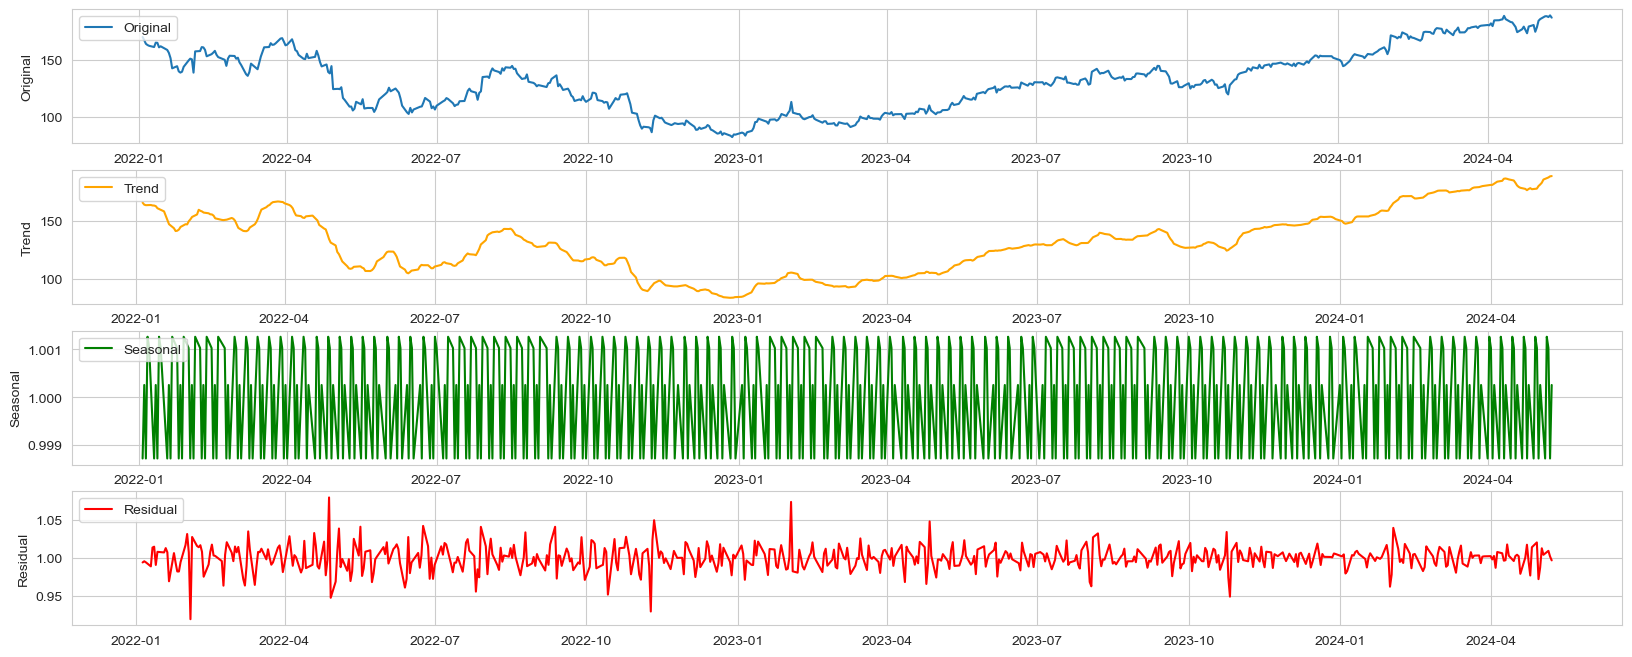

In [14]:
amazon_data = stock_df[stock_df['Company']=='AMZN']
amazon_df = pd.DataFrame(index = amazon_data['Date'])
amazon_df['Close'] = amazon_data['Close'].values

amazon_decompose = seasonal_decompose(amazon_df['Close'], model='multiplicative', period=5)
res = amazon_decompose.trend + amazon_decompose.seasonal + amazon_decompose.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 8))

ax1.plot(amazon_df.index, amazon_df['Close'], label='Original')
ax1.legend(loc='upper left')
ax1.set_ylabel('Original')

ax2.plot(amazon_df.index, amazon_decompose.trend, label='Trend', color='orange')
ax2.legend(loc='upper left')
ax2.set_ylabel('Trend')

ax3.plot(amazon_df.index, amazon_decompose.seasonal, label='Seasonal', color='green')
ax3.legend(loc='upper left')
ax3.set_ylabel('Seasonal')

ax4.plot(amazon_df.index, amazon_decompose.resid, label='Residual', color='red')
ax4.legend(loc='upper left')
ax4.set_ylabel('Residual')

plt.show()

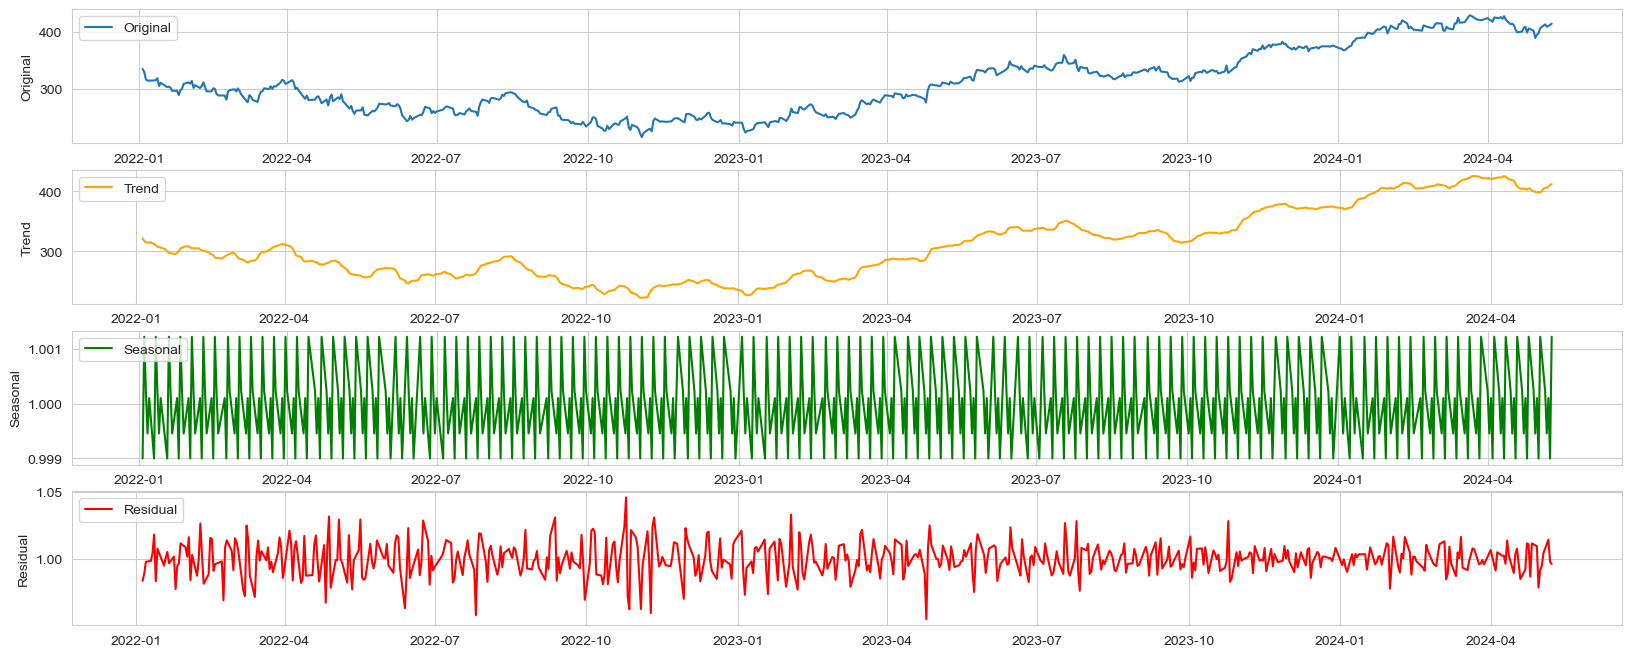

In [15]:
msft_data = stock_df[stock_df['Company']=='MSFT']
msft_df = pd.DataFrame(index = msft_data['Date'])
msft_df['Close'] = msft_data['Close'].values

msft_decompose = seasonal_decompose(msft_df['Close'], model='multiplicative', period=5)
res = msft_decompose.trend + msft_decompose.seasonal + msft_decompose.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 8))

ax1.plot(msft_df.index, msft_df['Close'], label='Original')
ax1.legend(loc='upper left')
ax1.set_ylabel('Original')

ax2.plot(msft_df.index, msft_decompose.trend, label='Trend', color='orange')
ax2.legend(loc='upper left')
ax2.set_ylabel('Trend')

ax3.plot(msft_df.index, msft_decompose.seasonal, label='Seasonal', color='green')
ax3.legend(loc='upper left')
ax3.set_ylabel('Seasonal')

ax4.plot(msft_df.index, msft_decompose.resid, label='Residual', color='red')
ax4.legend(loc='upper left')
ax4.set_ylabel('Residual')

plt.show()

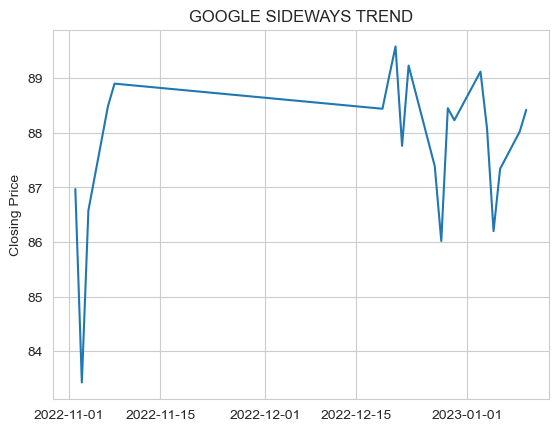

In [16]:
google_df_1 = google_df.copy()

# once again performing seasonal decomposition on google dataset close price
google_1_decompose = seasonal_decompose(google_df_1['Close'], model='multiplicative', period=5)
trend_component = google_1_decompose.trend

# identifying the sideways trend periods based on threshold
sideways_threshold = 90 ##### Adjust as needed #########
google_sideways_periods = trend_component[np.abs(trend_component) < sideways_threshold]

google_sideways_trend_dates_str = google_sideways_periods.index.strftime('%Y-%m-%d')

# Filter the original dataset based on the sideways trend dates
google_sideways_trend_data = stock_df[(stock_df['Company']=='GOOGL') & (stock_df['Date'].isin(google_sideways_trend_dates_str))]

plt.plot(google_sideways_trend_data['Date'],google_sideways_trend_data['Close'])
plt.title("GOOGLE SIDEWAYS TREND")
plt.ylabel("Closing Price")
plt.show()

In [17]:
np.round(google_sideways_trend_data[['Close','Volume']].corr(),2)

,Close,Volume
Close,1.0,-0.6
Volume,-0.6,1.0


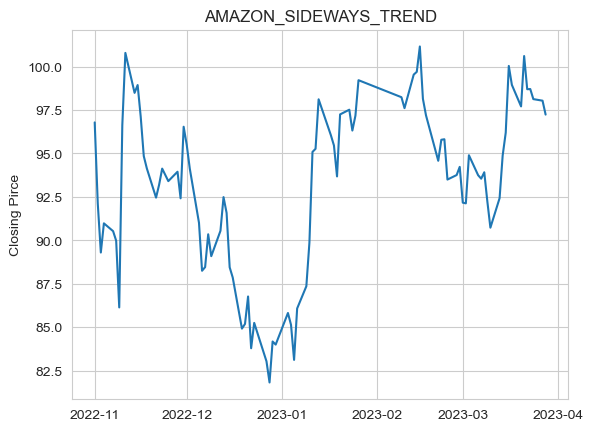

In [18]:
amzn_df_1 = amazon_df.copy()
amzn_1_decompose = seasonal_decompose(amzn_df_1['Close'], model='multiplicative', period=5)
trend_component = amzn_1_decompose.trend

sideways_threshold = 100 ##### Adjust as needed####
amzn_sideways_periods = trend_component[np.abs(trend_component) < sideways_threshold]

amzn_sideways_trend_dates_str = amzn_sideways_periods.index.strftime('%Y-%m-%d')

# Filter the original dataset based on the sideways trend dates
amzn_sideways_trend_data = stock_df[(stock_df['Company']=='AMZN') & (stock_df['Date'].isin(amzn_sideways_trend_dates_str))]

# Display the extracted data
amzn_sideways_trend_data[['Date','Close','Volume']]
plt.plot(amzn_sideways_trend_data['Date'],amzn_sideways_trend_data['Close'])
plt.title('AMAZON_SIDEWAYS_TREND')
plt.ylabel('Closing Pirce')
plt.show()

In [19]:
np.round(amzn_sideways_trend_data[['Close','Volume']].corr(),2)

,Close,Volume
Close,1.00,-0.01
Volume,-0.01,1.00


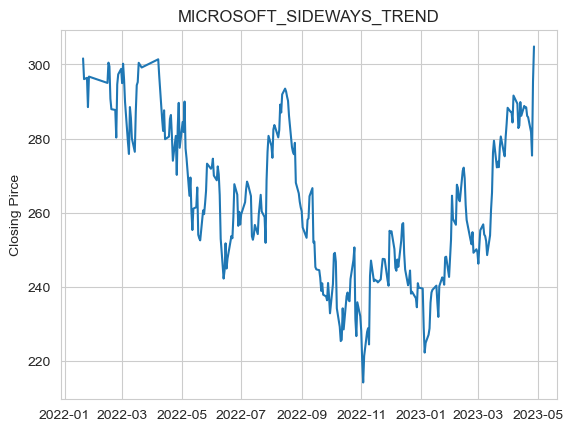

In [20]:
msft_df_1 = msft_df.copy()
msft_1_decompose = seasonal_decompose(msft_df_1['Close'], model='multiplicative', period=5)
trend_component = msft_1_decompose.trend

sideways_threshold = 300  #### Adjust as needed####

msft_sideways_periods = trend_component[np.abs(trend_component) < sideways_threshold]

msft_sideways_trend_dates_str = msft_sideways_periods.index.strftime('%Y-%m-%d')

# Filter the original dataset based on the sideways trend dates
msft_sideways_trend_data = stock_df[(stock_df['Company']=='MSFT') & (stock_df['Date'].isin(msft_sideways_trend_dates_str))]
plt.plot(msft_sideways_trend_data['Date'],msft_sideways_trend_data['Close'])
plt.title('MICROSOFT_SIDEWAYS_TREND')
plt.ylabel('Closing Pirce')
plt.show()

In [21]:
np.round(msft_sideways_trend_data[['Close','Volume']].corr(),2)

,Close,Volume
Close,1.00,0.07
Volume,0.07,1.00
